# 残差块
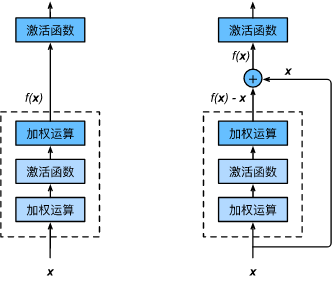
`ResNet`沿用了VGG全`3×3`卷积层的设计。残差块里首先有2个有相同输出通道数的`3×3`卷积层。每个卷积层后接一个批量归一化层和`ReLU`激活函数。然后我们将输入跳过这两个卷积运算后直接加在最后的`ReLU`激活函数前。这样的设计要求两个卷积层的输出与输入形状一样，从而可以相加。如果想改变通道数，就需要引入一个额外的`1×1`卷积层来将输入变换成需要的形状后再做相加运算。

残差块的实现如下。它可以设定输出通道数、是否使用额外的`1×1`卷积层来修改通道数以及卷积层的步幅。

In [1]:
import time
import torch
from torch import nn, optim
import torch.nn.functional as F

import sys
sys.path.append("../深度学习基础/") 
import d2lzh_pytorch as d2l
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
class Residual(nn.Module):  # 本类已保存在d2lzh_pytorch包中方便以后使用
    def __init__(self, in_channels, out_channels, use_1x1conv=False, stride=1):
        super(Residual, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
    
    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        return F.relu(Y + X)

下面我们来查看输入和输出形状一致的情况。

In [3]:
blk = Residual(3, 3)
X = torch.rand((4, 3, 6, 6))
blk(X).shape  # torch.Size([4, 6, 3, 3])

torch.Size([4, 3, 6, 6])

# ResNet模型
`ResNet`的前两层跟之前介绍的`GoogLeNet`中的一样：在输出通道数为64、步幅为2的`7×7`卷积层后接步幅为2的`3×3`的最大池化层。不同之处在于`ResNet`每个卷积层后增加的批量归一化层。

In [4]:
net = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

`GoogLeNet`在后面接了4个由`Inception`块组成的模块。`ResNet`则使用4个由残差块组成的模块，每个模块使用若干个同样输出通道数的残差块。第一个模块的通道数同输入通道数一致。由于之前已经使用了步幅为2的最大池化层，所以无须减小高和宽。之后的每个模块在第一个残差块里将上一个模块的通道数翻倍，并将高和宽减半。

下面我们来实现这个模块。注意，这里对第一个模块做了特别处理。

In [5]:
def resnet_block(in_channels, out_channels, num_residuals, first_block=False):
    if first_block:
        assert in_channels == out_channels  # 第一个模块的通道数同输入通道数一致
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(in_channels, out_channels, use_1x1conv=True, stride=2))
        else:
            blk.append(Residual(out_channels, out_channels))
    return nn.Sequential(*blk)

接着我们为`ResNet`加入所有残差块。这里每个模块使用两个残差块。

In [6]:
net.add_module("resnet_block1", resnet_block(64, 64, 2, first_block=True))
net.add_module("resnet_block2", resnet_block(64, 128, 2))
net.add_module("resnet_block3", resnet_block(128, 256, 2))
net.add_module("resnet_block4", resnet_block(256, 512, 2))

最后，与GoogLeNet一样，加入全局平均池化层后接上全连接层输出。

In [7]:
net.add_module("global_avg_pool", d2l.GlobalAvgPool2d())  # GlobalAvgPool2d的输出: (Batch, 512, 1, 1)
net.add_module("fc", nn.Sequential(d2l.FlattenLayer(), nn.Linear(512, 10)))

这里每个模块里有4个卷积层（不计算`1×1`卷积层），加上最开始的卷积层和最后的全连接层，共计18层。这个模型通常也被称为`ResNet-18`。通过配置不同的通道数和模块里的残差块数可以得到不同的`ResNet`模型，例如更深的含152层的`ResNet-152`。虽然`ResNet`的主体架构跟`GoogLeNet`的类似，但`ResNet`结构更简单，修改也更方便。这些因素都导致了`ResNet`迅速被广泛使用。

在训练`ResNet`之前，我们来观察一下输入形状在`ResNet`不同模块之间的变化。

In [8]:
X = torch.rand((1, 1, 224, 224))
for name, layer in net.named_children():
    X = layer(X)
    print(name, ' output shape:\t', X.shape)

0  output shape:	 torch.Size([1, 64, 112, 112])
1  output shape:	 torch.Size([1, 64, 112, 112])
2  output shape:	 torch.Size([1, 64, 112, 112])
3  output shape:	 torch.Size([1, 64, 56, 56])
resnet_block1  output shape:	 torch.Size([1, 64, 56, 56])
resnet_block2  output shape:	 torch.Size([1, 128, 28, 28])
resnet_block3  output shape:	 torch.Size([1, 256, 14, 14])
resnet_block4  output shape:	 torch.Size([1, 512, 7, 7])
global_avg_pool  output shape:	 torch.Size([1, 512, 1, 1])
fc  output shape:	 torch.Size([1, 10])


# 获取数据和训练模型
下面我们在Fashion-MNIST数据集上训练ResNet。

In [9]:
batch_size = 256
# 如出现“out of memory”的报错信息，可减小batch_size或resize
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)

lr, num_epochs = 0.001, 5
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
d2l.train_ch5(net, train_iter, test_iter, batch_size, optimizer, device, num_epochs)

training on  cuda
epoch 1, loss 0.3946, train acc 0.855, test acc 0.875, time 26.7 sec
epoch 2, loss 0.2478, train acc 0.909, test acc 0.882, time 23.4 sec
epoch 3, loss 0.2099, train acc 0.923, test acc 0.908, time 23.3 sec
epoch 4, loss 0.1822, train acc 0.933, test acc 0.898, time 23.2 sec
epoch 5, loss 0.1618, train acc 0.939, test acc 0.911, time 23.3 sec


# 小结
+ 残差块通过跨层的数据通道从而能够训练出有效的深度神经网络。
+ `ResNet`深刻影响了后来的深度神经网络的设计。